In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=2)

In [3]:
'''
somehow we need to get RNA data...
'''
from eden.converter.fasta import fasta_to_sequence
from eden.converter.rna.rnafold import rnafold_to_eden

def rfam_uri(family_id):
    return '%s.fa'%(family_id)
def rfam_uri(family_id):
    return 'http://rfam.xfam.org/family/%s/alignment?acc=%s&format=fastau&download=0'%(family_id,family_id)


def get_graphs(rfam_id = 'RF00005'):
    seqs = fasta_to_sequence(rfam_uri(rfam_id))
    graphs = rnafold_to_eden(seqs, shape_type=5, energy_range=30, max_num=3)
    return graphs


Starting new HTTP connection (1): rfam.xfam.org
"GET /family/RF00005/alignment?acc=RF00005&format=fastau&download=0 HTTP/1.1" 200 90476
original


/home/ikea/.local/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/home/ikea/.local/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


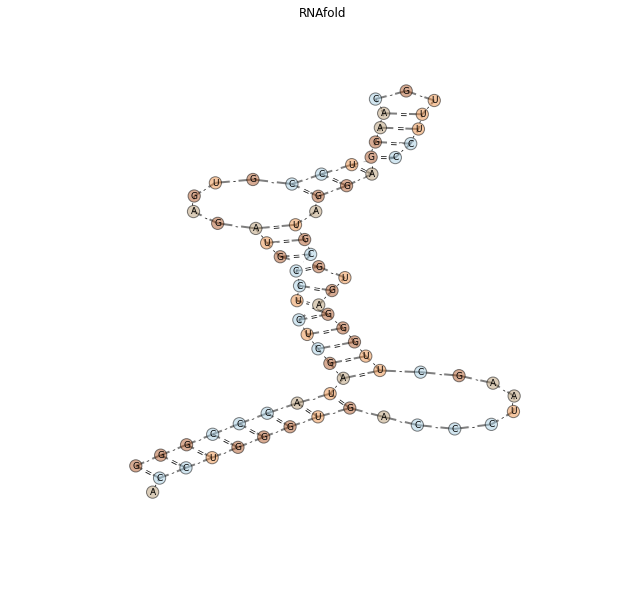

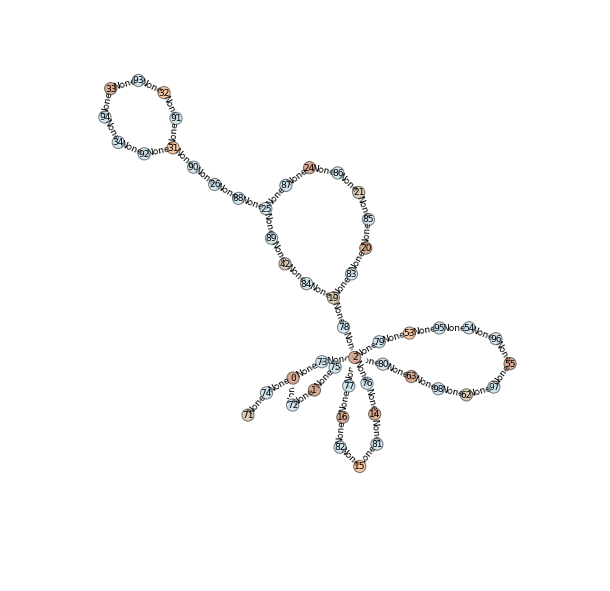

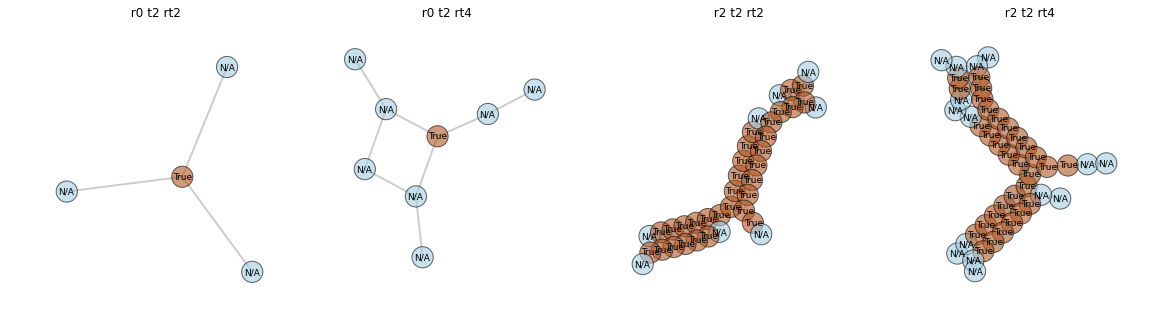

In [4]:
'''
first we test the core/interface extractor, since it is most essential
'''
import sys
sys.path.append('../graphlearn')
%matplotlib inline
from eden.converter.graph.gspan import gspan_to_eden


import graphlearn.abstract_graphs.ubergraphlearn as ul
import graphlearn.graphtools as gt
import graphlearn.utils.draw as myutils
import eden.graph as eg
import numpy as np

from eden.graph import Vectorizer
vectorizer=Vectorizer()

#get a graph
graphs = get_graphs()
graph=graphs.next()
from eden.util import display
from eden.modifier.graph.vertex_attributes import colorize  
graphs = colorize([graph],output_attribute = 'color_level', labels = ['C','A','U','G'])    
graph=graphs.next()
print 'original'
display.draw_graph(graph, size=10,
                   colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
                   vertex_alpha=0.5, node_size=150)



def zomg(graph):
    return graph.graph['stuff']

def mark_and_draw(cips):
    #graph=myutils.cip_to_graph(cip)
    
    graph=[]
    for ci in cips:
        ci.graph.graph['stuff']='  r%d t%d rt%d' % (ci.radius,ci.abstract_thickness,ci.thickness)
        graph.append(ci.graph)
    
    myutils.draw_graph_set_graphlearn(graph, 
                           n_graphs_per_line=4, size=5, 
                           colormap='Paired', invert_colormap=False,node_border=1,
                           vertex_alpha=0.6, edge_alpha=0.2, node_size=450, headlinehook=zomg, vertex_label='core')
    
radius_list=[0,2]
thickness_list=[2]
rtl=[2,4]
graph=vectorizer._edge_to_vertex_transform(graph)
#print 'expanded'
#myutils.display(graph,size=10,edge_label=None)
abs= ul.make_abstract(graph,vectorizer)

myutils.set_ids(abs)
display.draw_graph(abs, size=10,
                   colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
                   vertex_alpha=0.5, node_size=150,vertex_label='id')


#print 'abstr'
#myutils.display(abs,size=10,edge_label=None)

cips=ul.extract_cips(
    53,
    abs,
    graph,
    abstract_radius_list=radius_list,
    abstract_thickness_list=thickness_list,
    base_thickness_list=rtl,
    vectorizer=vectorizer,
    filter=lambda x,y:True,
    hash_bitmask=2**20-1)
mark_and_draw(cips)


In [6]:
%%time
'''
second is reading a grammar and training an estimator
'''
import os 
os.nice(20)
%matplotlib inline
import graphlearn.utils.draw as myutils
import graphlearn.abstract_graphs.ubergraphlearn as ul
import itertools

# learn a grammar
graphs = get_graphs()
graphs = itertools.islice(graphs,200)

sampler=ul.UberSampler(radius_list=[0,1,2],thickness_list=[2],base_thickness_list=[0.5,1], core_interface_pair_remove_threshold=1, interface_remove_threshold=2)
sampler.fit(graphs,n_jobs=4,batch_size=3)
sampler.save('tmp/rna_ubergrammar.ge')



Starting new HTTP connection (1): rfam.xfam.org
"GET /family/RF00005/alignment?acc=RF00005&format=fastau&download=0 HTTP/1.1" 200 90476

Classifier:
SGDClassifier(alpha=0.000240111853851, average=False, class_weight=None,
       epsilon=0.1, eta0=0.83448566316, fit_intercept=True, l1_ratio=0.15,
       learning_rate='constant', loss='log', n_iter=81, n_jobs=1,
       penalty='l1', power_t=0.888131784161, random_state=None,
       shuffle=True, verbose=0, warm_start=False)

Predictive performance:
            accuracy: 1.000 +- 0.000
           precision: 1.000 +- 0.000
              recall: 1.000 +- 0.000
                  f1: 1.000 +- 0.000
   average_precision: 1.000 +- 0.000
             roc_auc: 1.000 +- 0.000
Saved model: tmp/rna_ubergrammar.ge
CPU times: user 1min 24s, sys: 4.54 s, total: 1min 28s
Wall time: 2min 30s


interface: 262169


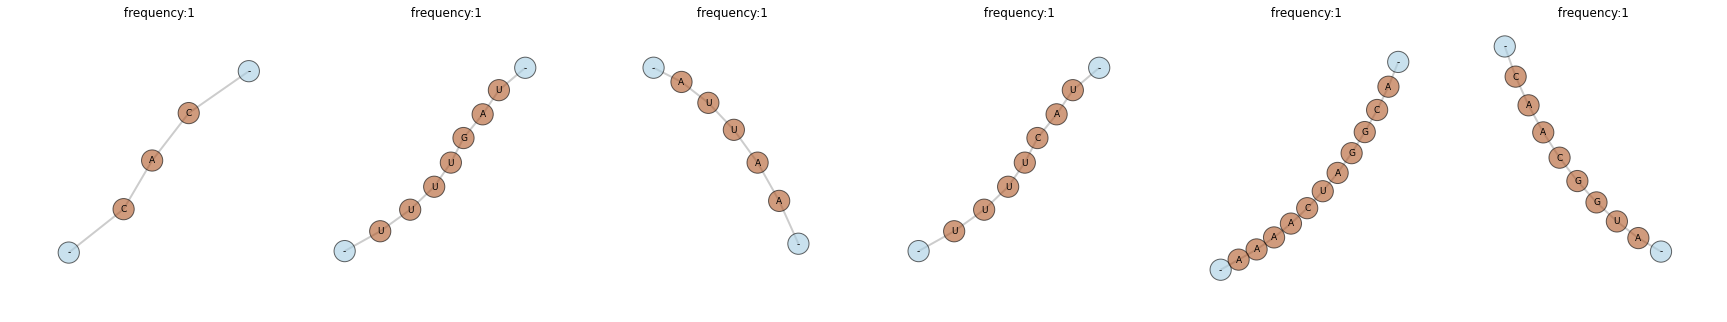

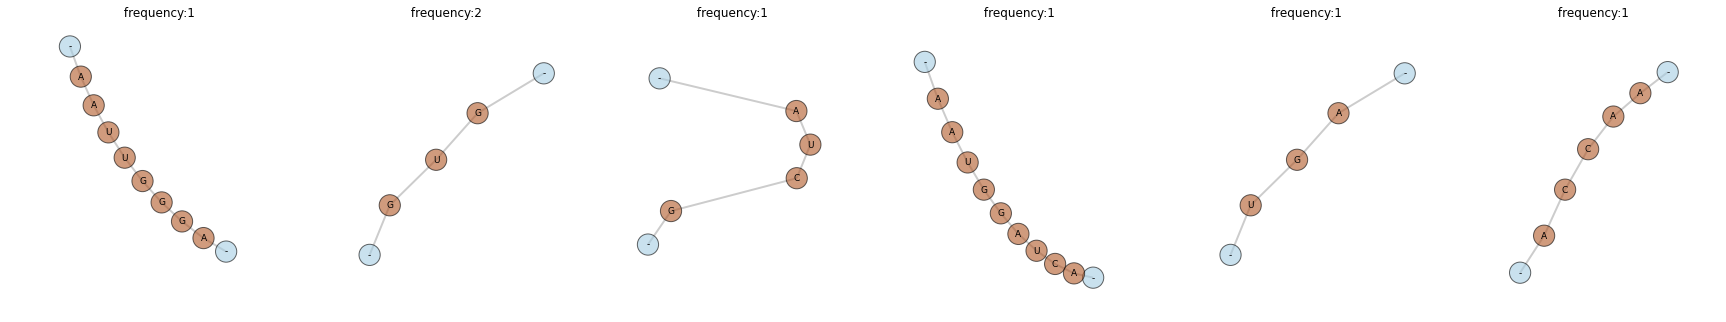

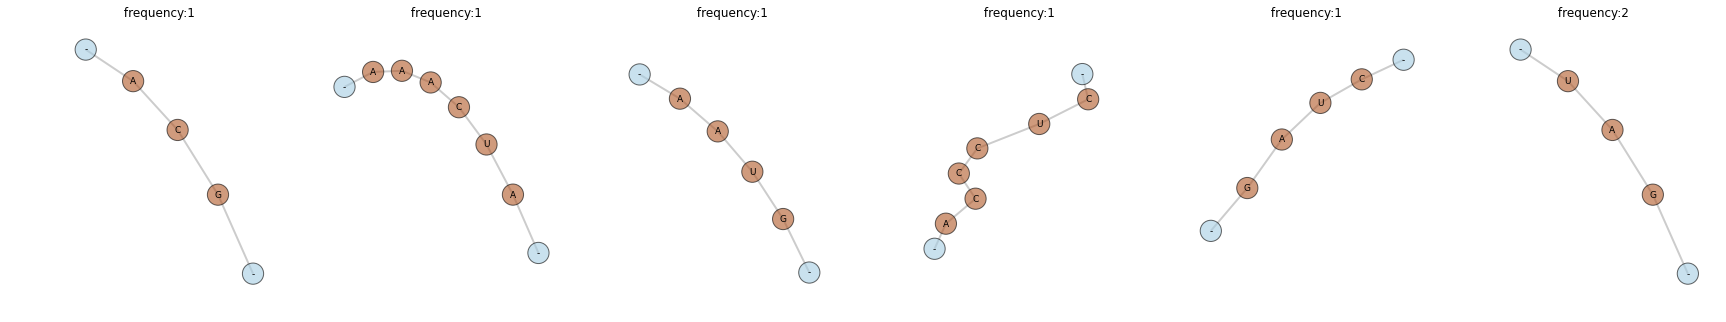

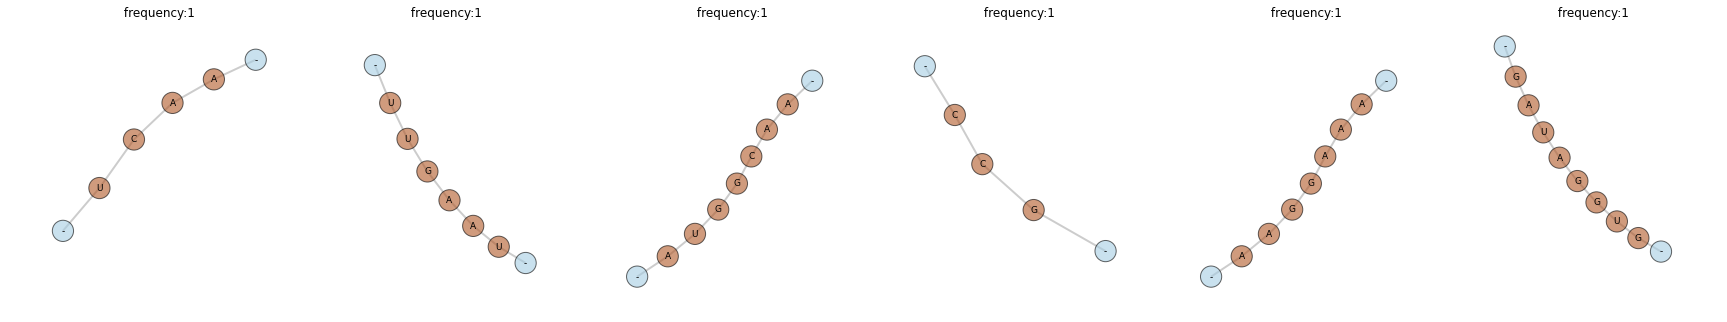

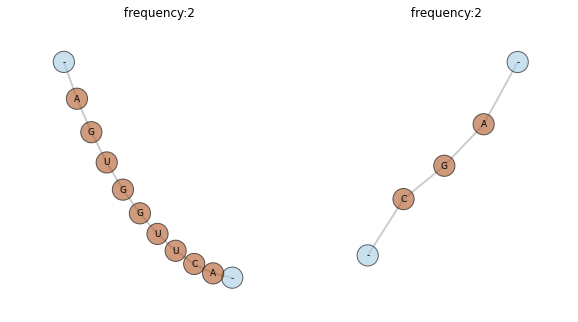

interface: 983066


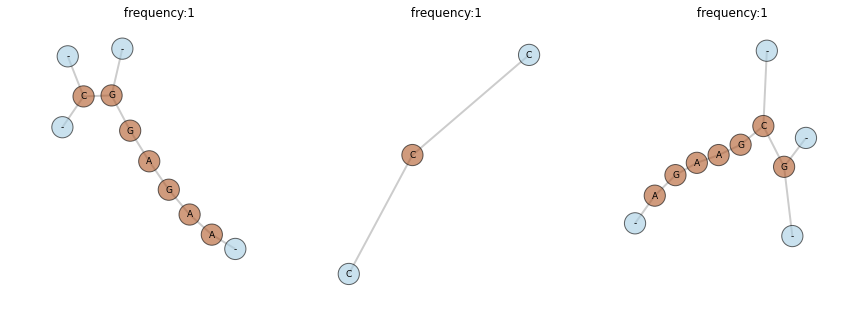

interface: 819238


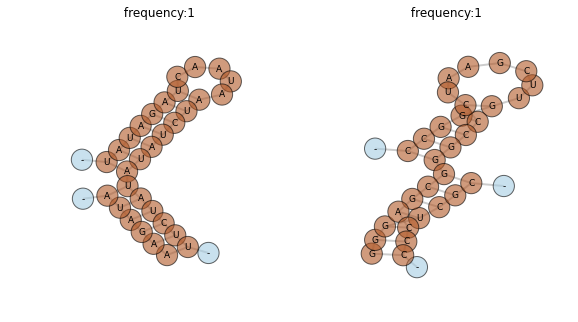

interface: 458795


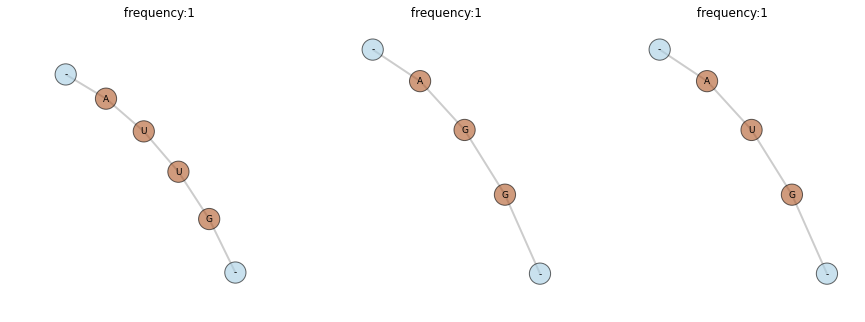

interface: 86


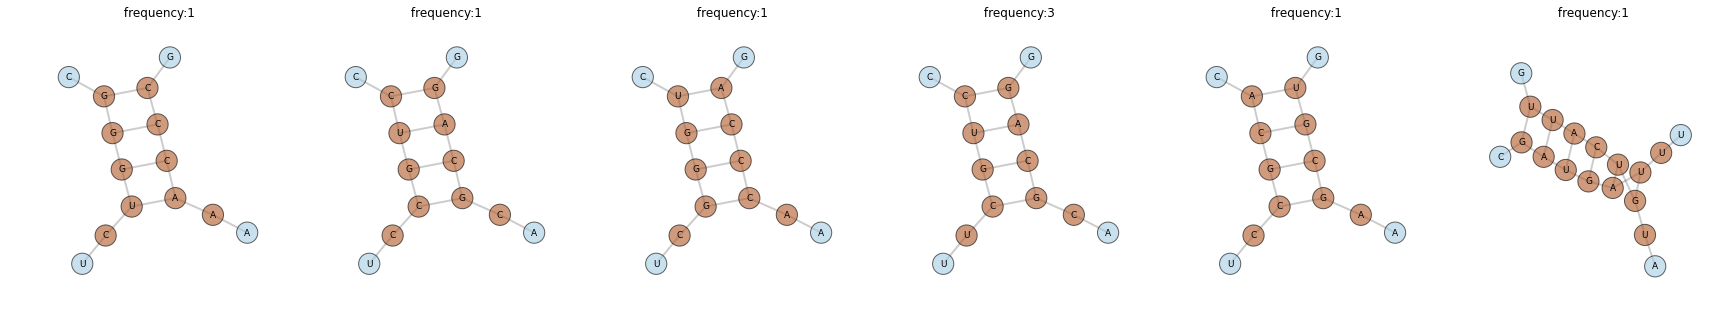

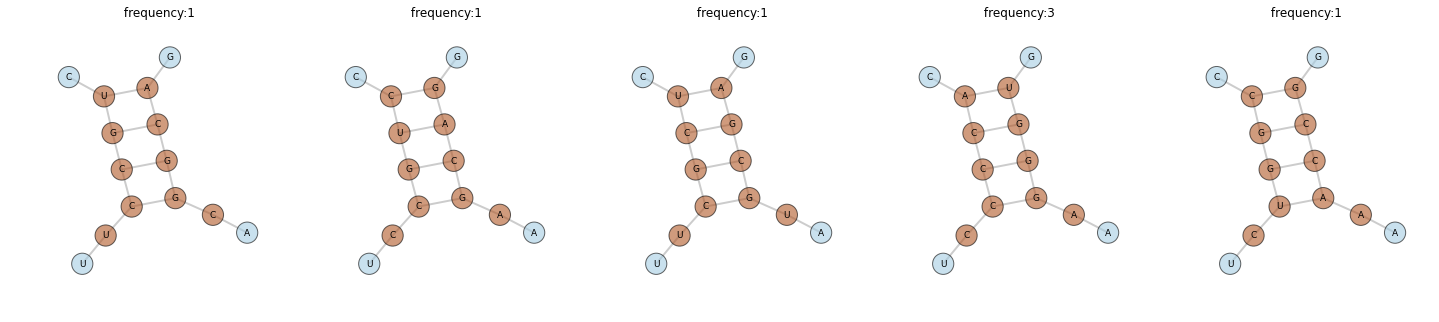

In [7]:
#draw production rules
myutils.draw_grammar(sampler.local_substitutable_graph_grammar.grammar,n_productions=5,
                     n_graphs_per_line=6, size=5, 
                     colormap='Paired', invert_colormap=False,node_border=1,
                     vertex_alpha=0.6, edge_alpha=0.2, node_size=450)

how often do we see interfacehashes
# productions: 9599
x = # interfaces (total: 2977)
y=numberofcores(ihash), y=sumOfCoreCounts(ihash)


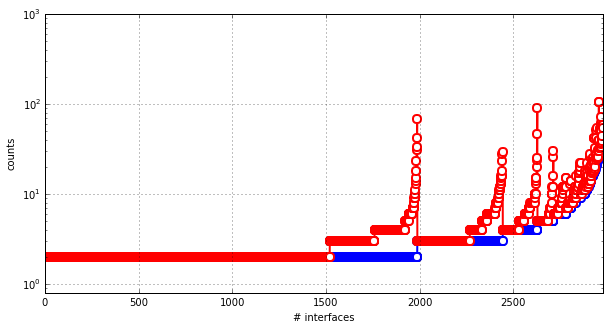

how often was this corehash seen?
x = # cores (total: 3356)
y = inYinterfaces(chash), y= sumOfCountOverAllInterfaces(chash)


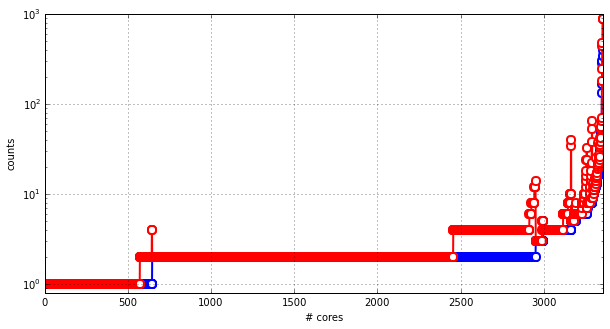

histogram
# productions: 9599
distinct cores: 3356 (seen on x axis)
interfaces with x many cores were observed y many times. 


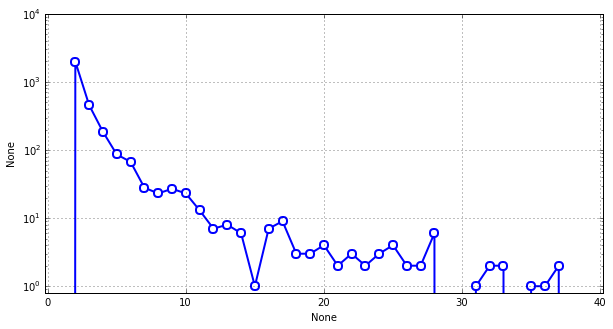

other histogram
how many cores exist with x many interfaces


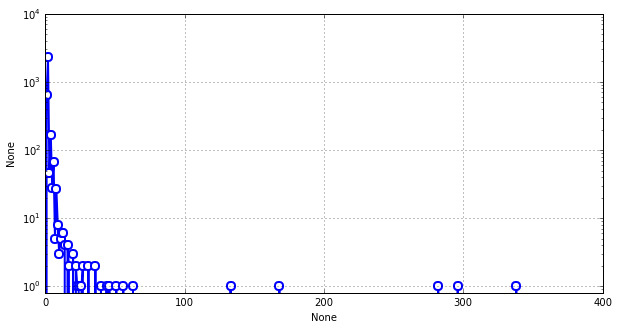

In [8]:
#grammar statistics
myutils.draw_grammar_stats(sampler.local_substitutable_graph_grammar.grammar, size=(10,5))

Loaded model: tmp/rna_ubergrammar.ge
preprocessing grammar
_sample_notes: None
accept_annealing_factor: 0.0
accept_static_penalty: 0.0
base_thickness_list: [1, 2]
batch_size: 1
   burnout: 0
complexity: 3
 estimator: CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.000240111853851, average=False, class_weight=None,
       epsilon=0.1, eta0=0.83448566316, fit_intercept=True, l1_ratio=0.15,
       learning_rate='constant', loss='log', n_iter=81, n_jobs=1,
       penalty='l1', power_t=0.888131784161, random_state=None,
       shuffle=True, verbose=0, warm_start=False),
            cv=2, method='sigmoid')
estimatorobject: <graphlearn.estimator.estimator instance at 0x7f0a4cd79f38>
feasibility_checker: <graphlearn.feasibility.FeasibilityChecker instance at 0x7f0a4cd79ea8>
generatormode: False
hash_bitmask: 1048575
keep_duplicates: True
local_substitutable_graph_grammar: <graphlearn.abstract_graphs.ubergraphlearn.UberGrammar object at 0x7f0a747ab650>
    n_jobs: 4
   n_steps: 50
 

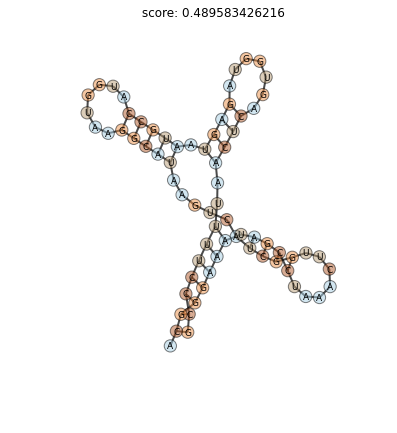

Graph id: 16
iteration:8
iteration:6
iteration:23
Working with 9 cores
Working with 3 cores
Working with 32 cores
Working with 4 cores
iteration:12
iteration:9
iteration:7
iteration:24
Working with 2 cores
Working with 5 cores
Working with 3 cores
Working with 8 cores
iteration:13
iteration:10
iteration:8
iteration:25
Working with 9 cores
Working with 4 cores
Working with 3 cores
Working with 2 cores
iteration:14
iteration:11
iteration:9
iteration:26
Working with 4 cores
Working with 22 cores
Working with 25 cores
Working with 4 cores
iteration:15
iteration:12
iteration:10
ERROR: empty graph
Working with 9 cores
Working with 5 cores
Working with 32 cores
feasibility checker failed
iteration:16
iteration:13
iteration:11
ERROR: empty graph
Working with 2 cores
Working with 2 cores
Working with 3 cores
feasibility checker failed
ERROR: empty graph
iteration:14
iteration:12
ERROR: empty graph
feasibility checker failed
Working with 2 cores
Working with 3 cores
feasibility checker failed
ER

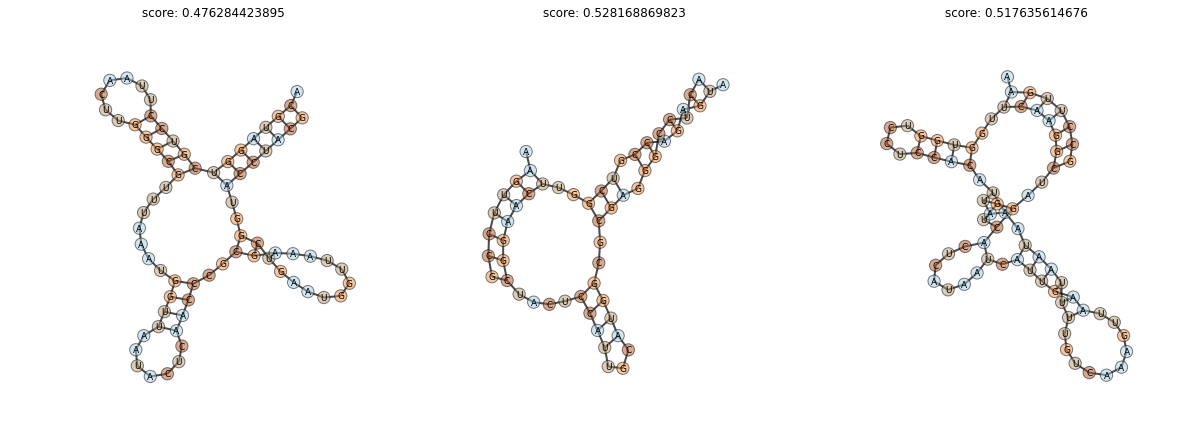

Graph id: 17
iteration:13
Working with 11 cores
Working with 25 cores
Working with 2 cores
Working with 2 cores
iteration:9
iteration:15
iteration:21
iteration:14
Working with 2 cores
Working with 2 cores
Working with 19 cores
Working with 4 cores
iteration:10
iteration:16
iteration:22
iteration:15
Working with 4 cores
Working with 5 cores
Working with 2 cores
Working with 9 cores
iteration:11
iteration:17
iteration:23
iteration:16
Working with 7 cores
Working with 25 cores
Working with 5 cores
Working with 3 cores
iteration:12
iteration:18
iteration:24
iteration:17
Working with 2 cores
Working with 25 cores
Working with 3 cores
Working with 6 cores
iteration:13
iteration:19
iteration:25
iteration:18
Working with 3 cores
Working with 5 cores
Working with 2 cores
iteration:14
iteration:20
iteration:19
Working with 10 cores
Working with 6 cores
Working with 11 cores
iteration:21
iteration:20
Working with 5 cores


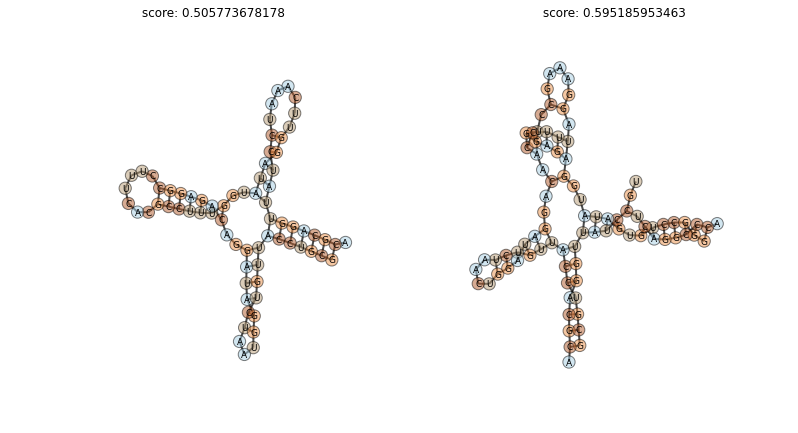

Graph id: 18
iteration:15
iteration:22
Working with 16 cores
Working with 22 cores
Working with 2 cores
Working with 3 cores
iteration:26
iteration:21
iteration:16
iteration:23
Working with 5 cores
Working with 3 cores
Working with 10 cores
Working with 2 cores
iteration:27
iteration:22
iteration:17
iteration:24
Working with 5 cores
Working with 2 cores
Working with 7 cores
Working with 11 cores
iteration:28
iteration:23
iteration:18
iteration:25
Working with 6 cores
Working with 6 cores
Working with 10 cores
Working with 11 cores
iteration:29
iteration:24
iteration:19
iteration:26
Working with 5 cores
Working with 2 cores
Working with 4 cores
Working with 2 cores
iteration:30
iteration:25
iteration:20
ERROR: empty graph
Working with 5 cores
Working with 2 cores
feasibility checker failed
iteration:26
iteration:21
ERROR: empty graph
Working with 3 cores
Working with 26 cores
feasibility checker failed
iteration:27
iteration:22
select_randomized_cips_from_grammar didn't find any accepta

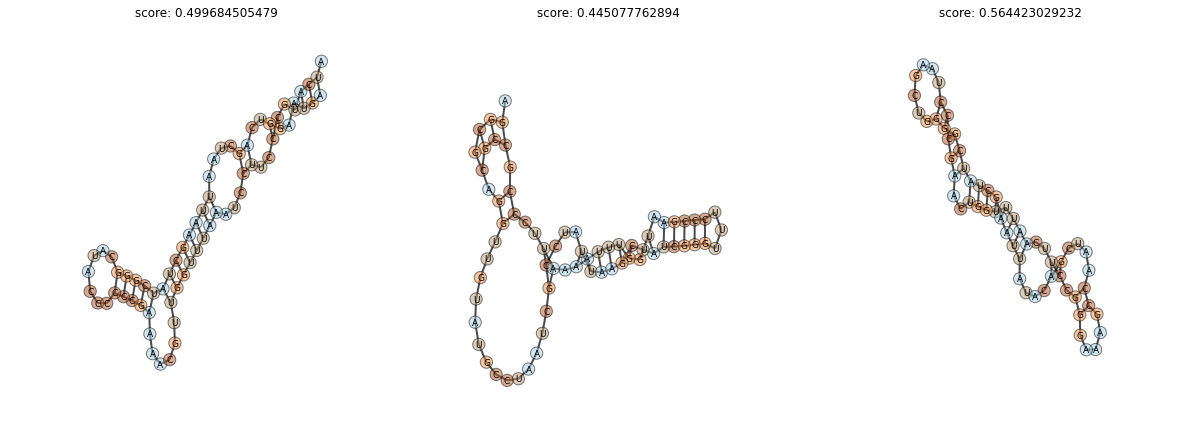

Graph id: 19
iteration:32
Working with 10 cores
iteration:9
Working with 2 cores
Working with 2 cores
iteration:31
Working with 7 cores
iteration:29
iteration:33
Working with 3 cores
iteration:10
Working with 10 cores
Working with 6 cores
iteration:32
Working with 3 cores
iteration:30
iteration:34
Working with 4 cores
iteration:11
Working with 28 cores
Working with 4 cores
iteration:33
Working with 6 cores
iteration:31
iteration:35
Working with 4 cores
iteration:12
Working with 3 cores
Working with 25 cores
iteration:34
Working with 3 cores
iteration:32
iteration:36
Working with 2 cores
iteration:13
Working with 4 cores
Working with 2 cores
iteration:35
Working with 3 cores
iteration:33
iteration:37
Working with 3 cores
iteration:14
Working with 25 cores
Working with 11 cores
iteration:36
Working with 10 cores
iteration:34
iteration:38
Working with 4 cores
iteration:15
Working with 26 cores
Working with 3 cores
iteration:37
Working with 5 cores
iteration:35
iteration:39
Working with 6 

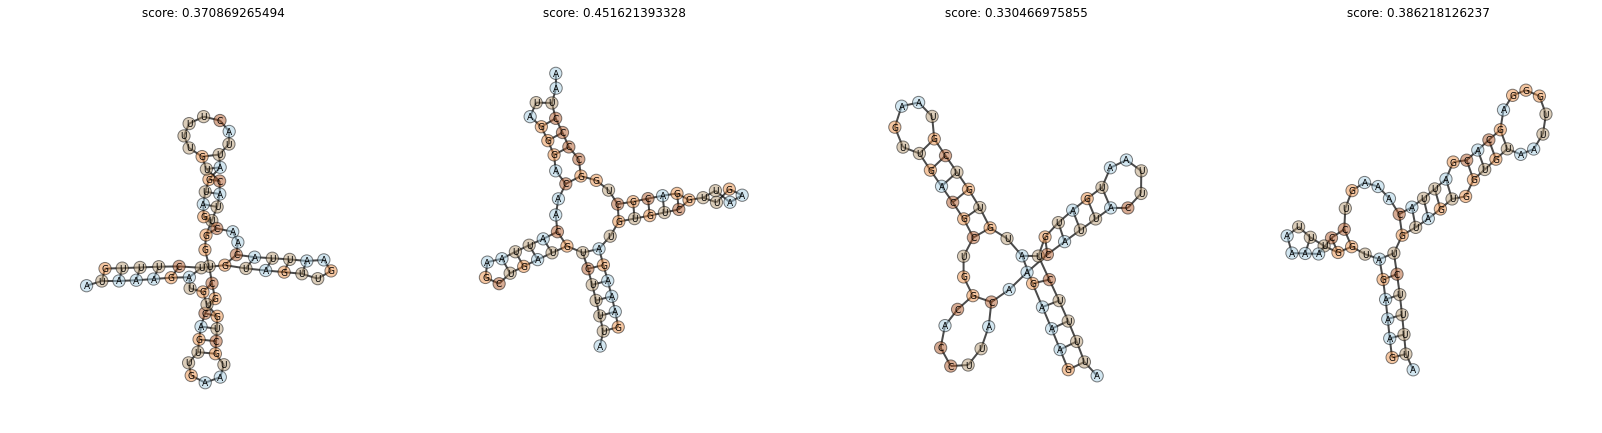

Graph id: 20
Working with 2 cores
Working with 5 cores
iteration:0
Working with 2 cores
iteration:26
iteration:42
Working with 2 cores
iteration:47
Working with 5 cores
Working with 3 cores
iteration:1
Working with 28 cores
iteration:27
iteration:43
Working with 4 cores
iteration:48
Working with 8 cores
Working with 2 cores
iteration:2
Working with 2 cores
iteration:28
iteration:44
Working with 12 cores
ERROR: empty graph
Working with 2 cores
iteration:3
feasibility checker failed
iteration:29
Working with 6 cores
ERROR: empty graph
Working with 6 cores
iteration:4
feasibility checker failed
iteration:30
Working with 4 cores
select_randomized_cips_from_grammar didn't find any acceptable cip in 
Working with 3 cores
iteration:5
Traceback (most recent call last):
  File "graphlearn/graphlearn.py", line 239, in _sample
    candidate_graph = self._propose(graph)
  File "graphlearn/graphlearn.py", line 376, in _propose
    graph = self._propose_graph(graph)
  File "graphlearn/graphlearn.py"

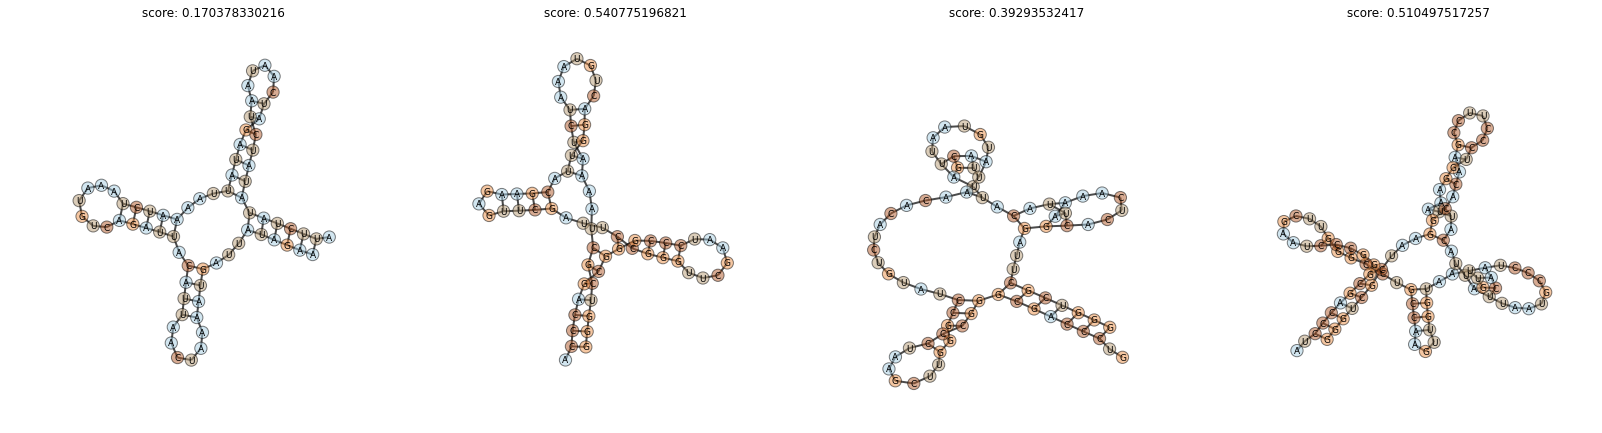

Graph id: 21
Working with 3 cores
Working with 4 cores
Working with 3 cores
iteration:19
iteration:45
iteration:40
Working with 3 cores
Working with 11 cores
iteration:20
iteration:46
Working with 2 cores
iteration:21
Working with 11 cores
iteration:22


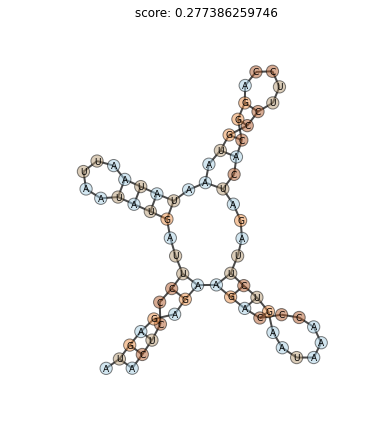

Graph id: 22
Working with 36 cores
Working with 2 cores
Working with 3 cores
iteration:47
iteration:23
iteration:41
Working with 2 cores
Working with 11 cores
Working with 9 cores
iteration:48
iteration:24
iteration:42
Working with 11 cores
Working with 11 cores
Working with 9 cores
iteration:49
iteration:25
iteration:43
Working with 11 cores
Working with 9 cores
Working with 8 cores
iteration:44
iteration:26
Working with 3 cores
Working with 23 cores
iteration:45
iteration:27
Working with 31 cores
Working with 3 cores
iteration:46
iteration:28
Working with 4 cores
Working with 8 cores
iteration:47
iteration:29
Working with 3 cores
Working with 9 cores
iteration:48
iteration:30
Working with 7 cores
Working with 3 cores
iteration:49
iteration:31
Working with 3 cores
Working with 9 cores
iteration:32
Working with 8 cores
iteration:33
Working with 14 cores
iteration:34
Working with 3 cores
iteration:35
Working with 7 cores
iteration:36


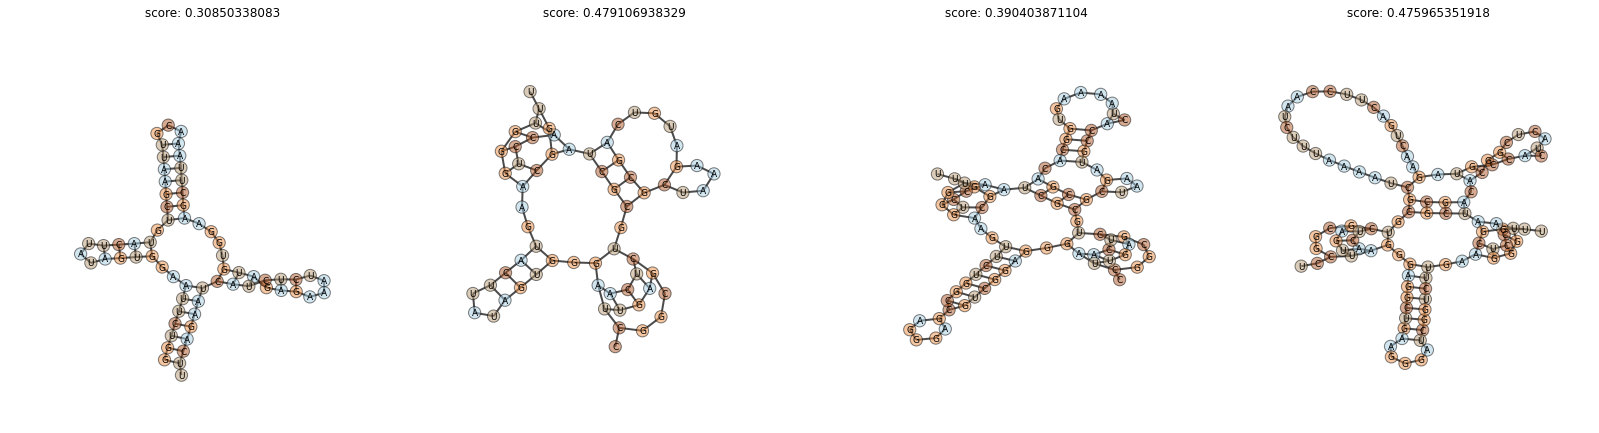

Graph id: 23
Working with 9 cores
iteration:37
Working with 2 cores
iteration:38
Working with 8 cores
iteration:39


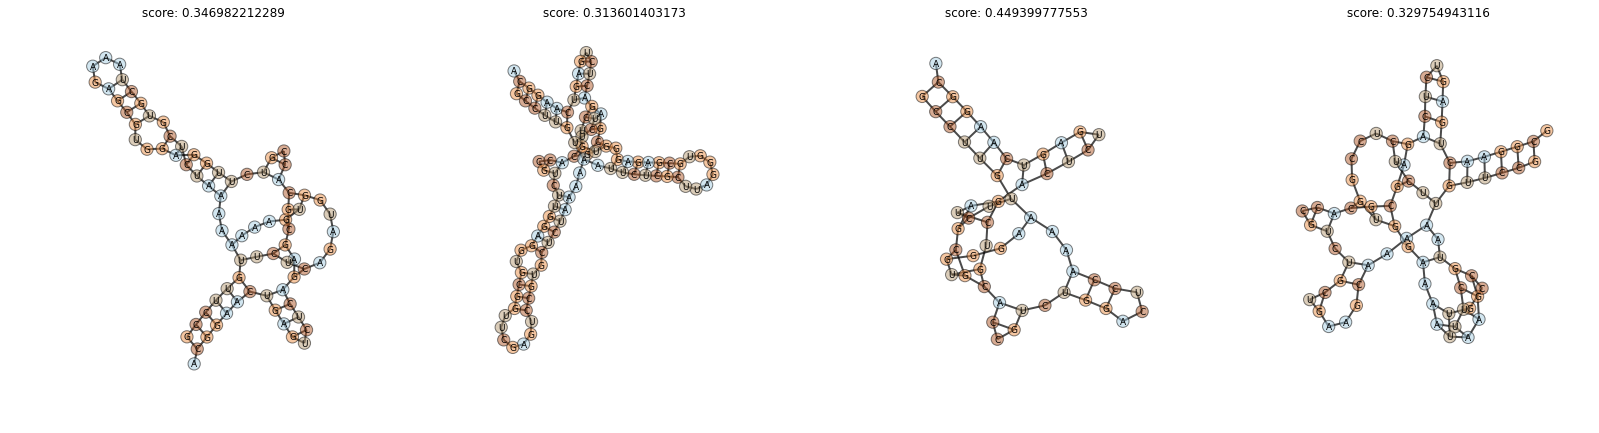

Graph id: 24
Working with 3 cores
iteration:40
Working with 4 cores
iteration:41
Working with 2 cores
iteration:42
Working with 17 cores
iteration:43
Working with 17 cores
iteration:44
Working with 10 cores
iteration:45
Working with 3 cores
iteration:46
Working with 4 cores
iteration:47
Working with 3 cores
iteration:48
Working with 5 cores
iteration:49
Working with 17 cores


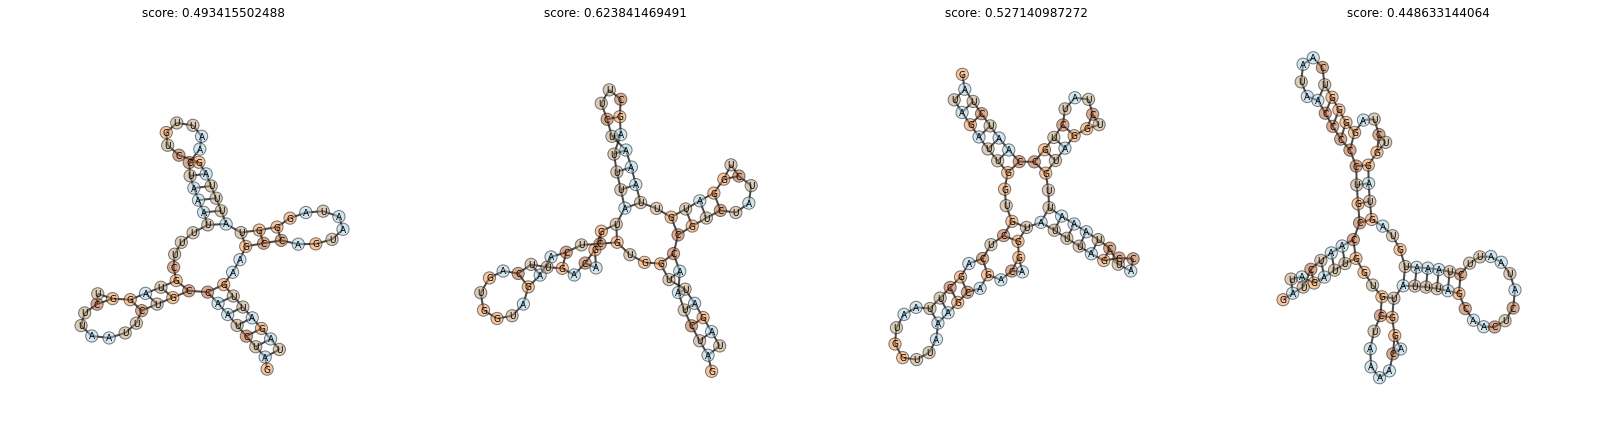

CPU times: user 41.2 s, sys: 4.98 s, total: 46.2 s
Wall time: 1min 25s


In [5]:
%%time
'''
Graph sampling
'''
import os
os.nice(19)
%matplotlib inline
#import mpld3
#mpld3.enable_notebook()
import graphlearn.utils.draw as myutils
import graphlearn.abstract_graphs.ubergraphlearn as ul
from eden.converter.graph.gspan import gspan_to_eden
import itertools
import matplotlib.pyplot as plt
import graphlearn.utils.draw as myutils
import eden.graph as ge

sampler=ul.UberSampler()
sampler.load('tmp/rna_ubergrammar.ge')
graphs = get_graphs()

id_start=15
id_end=id_start+10
graphs = itertools.islice(graphs,id_start,id_end)
n_steps=50

graphs = sampler.sample(graphs,
                        same_radius=False,
                        same_core_size=False,
                        n_samples=4,
                        batch_size=1,
                        n_steps=n_steps,
                        n_jobs=4,
                        accept_annealing_factor=0.0,
                        probabilistic_core_choice=True,
                        burnout=0,
                        select_cip_max_tries=200,
                        keep_duplicates=True)

from eden.modifier.graph.vertex_attributes import colorize   
scores=[]
ids=range(id_start,id_end)
for i,graph in enumerate(graphs):
    print 'Graph id: %d'%(ids[i])
    scores.append(graph.graph['sampling_info']['score_history'])
    path_graphs = graph.graph['sampling_info']['graphs_history']
    path_graphs = colorize(path_graphs,
                           output_attribute = 'color_level', 
                           labels = ['A','U','G','C'])
    myutils.draw_graph_set(path_graphs,
                           n_graphs_per_line=6, size=7, 
                           colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
                           vertex_alpha=0.5, edge_alpha=0.7, node_size=150,
                          headlinehook= myutils.get_score_of_graph
                          )
    

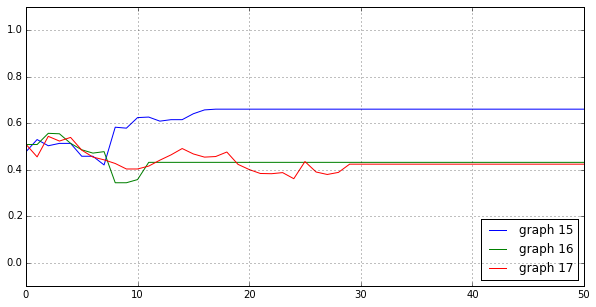

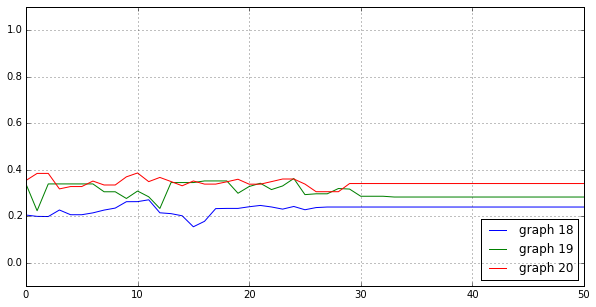

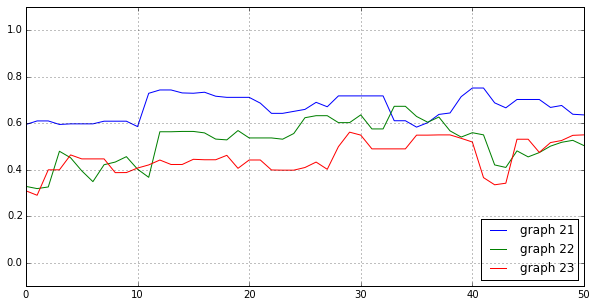

In [10]:
%matplotlib inline
from itertools import islice
import numpy as np

step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):
    plt.figure(figsize=(10,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
        data = list(islice(score,None, None, step))
        plt.plot(data, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
    plt.legend(loc='lower right')
    plt.grid()
    plt.ylim(-0.1,1.1)
    plt.show()